    What is the canopy height?
    What about the step change in roughness...

    No enhancement ET downwind of roughness in Baldochi - feature of the model... 

     The z0 values over the desert and the field 
     respectively were taken as 0.005 m and 0.05 m. 
     The surface roughness for heat and moisture (z0r) was assumed to be zo/5 

𝑅_𝑛−𝐺_𝑠=𝐿𝐸+𝐻

𝑅_𝑛=(1 − 𝛼_𝑠 ) 𝑅_𝑠𝑖+𝑅_𝑖𝑙−𝜖_𝑠 𝜎𝑇_𝑠^4

𝛼_𝑠  depends on soil moisture


In [26]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import pandas as pd
import numpy as np

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *



CPU times: user 1 ms, sys: 2.04 ms, total: 3.05 ms
Wall time: 2.52 ms


In [27]:
import xarray as xr
ds = xr.open_dataset("data_stream-oper_stepType-instant.nc", engine='h5netcdf')

In [28]:
lat = ds['latitude'].values
lon = ds['longitude'].values

# Coordinates of interest
lat_point = 45.6667
lon_point = -119.6667

# Find the closest indices
lat_idx = (np.abs(lat - lat_point)).argmin() + 1
lon_idx = (np.abs(lon - lon_point)).argmin() + 1

# Extract data at the closest point
data_at_point = ds.isel(latitude=lat_idx, longitude=lon_idx)


In [29]:
def get_lm(k,h,z, option = 'kz'):
    """
    mixing length option
    """
    d = 2/3*h
    
    if option == 'kz':
        lm = k*z
    else:
        a = 1
        lm = k*z   #  k*a*(h/3)
        lm[z < a*(h - d)] = k*a*h/3 
        # mixing length continuous, persist 1/2 canopy
        # height roughness sublayer effects.
        # z > 3/2 h mixing length model is working
    
    return lm

# take into account canopy sublayer effects,
# above d, no attached sublayer to ground
# roughness sublayer - transition 
# region between d and h, eddies are constant, b/c wakes, eddies, flow inside canopy a little slow
# don't scale distance from boundary
# canopy creates own regime
# z increments zero plane displacement

In [30]:
# def integrate_H2O_implicit(n, m, dx, dz, A, B, C, Qup, Q_s, Q_a):
#     """
#     This function computes the coefficients
#       of the second-order system of variable s(t+dt)
#       formed by the (known) profile values at s(t).
      
#       The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
#       The coefficients in AA4 are used from s(t)
#       The coefficients in AA1 are mainly the diffusion
#       The coefficients in AA2 include advection
#       The coefficients in AA3 include advection + s(t+dt)  
#     """
#     # Setup the tridiagonal solver for mean H2O concentration
#     AA1 = - A * B
#     AA2 = - C * B
#     AA3 = 1 / dx
#     AA4 = Qup / dx
    
#     upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
#     dia = (-2 * AA1 / (dz ** 2) + AA3)
#     lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
#     co = np.zeros(m)
#     co[:] = AA4

#     # Ensure the boundary conditions are state, not flux
#     lod[0] = 0
#     lod[m-1] = 0
#     dia[0] = 1
#     dia[m-1] = 1
#     upd[0] = 0
#     upd[m-1] = 0

#     # Enforce surface and upper H2O concentration

#     co[0] = Q_s
#     co[m-1] = Q_a

#     # Call the tridiagonal solver
#     Q1 = thomas(lod, dia, upd, co)

#     dQdz = our_central_difference(Q1, dz)

#     # Fq = - A * dQdz
    
    
#     return Q1, Fq


# def integrate_T_implicit(n, m, dx, dz, A, B, C, Tup, Ts, Ta):
#     """
#     This function computes the coefficients
#       of the second-order system of variable s(t+dt)
#       formed by the (known) profile values at s(t).
      
#       The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
#       The coefficients in AA4 are used from s(t)
#       The coefficients in AA1 are mainly the diffusion
#       The coefficients in AA2 include advection
#       The coefficients in AA3 include advection + s(t+dt)  
#     """
#     # Setup the tridiagonal solver for mean H2O concentration
#     AA1 = - A * B
#     AA2 = - C * B
#     AA3 = 1 / dx
#     AA4 = Tup / dx
    
#     upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
#     dia = (-2 * AA1 / (dz ** 2) + AA3)
#     lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
#     co = np.zeros(m)
#     co[:] = AA4

#     # Ensure the boundary conditions are state, not flux
#     lod[0] = 0
#     lod[m-1] = 0
#     dia[0] = 1
#     dia[m-1] = 1
#     upd[0] = 0
#     upd[m-1] = 0

#     # Enforce surface and upper H2O concentration
#     co[0] = Ts
#     co[-1] = Ta

#     # Call the tridiagonal solver
#     T1 = thomas(lod, dia, upd, co)
#     dTdz = our_central_difference(T1, dz)
    
#     FT = - A * dTdz 
#     return T1, FT


def vapor_concentration_RH( T, RH = 100):
    """
    Calculate the vapor concentration (in g/m³) for a given 
    relative humidity (RH) and temperature (T in °C).
    
    Parameters:
    - RH (float): Relative humidity as a fraction (e.g., 0.5 for 50%).
    - T (float): Temperature in degrees Celsius.
    
    Returns:
    - float: Vapor concentration in g/m³.
    """
    # Constants
    M_w = 18.015  # molar mass of water vapor in g/mol
    R = 8.314  # universal gas constant in J/(mol*K)
    
    # Calculate the saturation vapor pressure (Pa)
    e_s = 6.1094 * math.exp((17.625 * T) / (T + 243.04))*100

    # Actual vapor pressure (Pa)
    e = RH/100 * e_s
    
    # Vapor concentration (g/m³)
    C = (e * M_w) / (R * (T + 273.15))
    
    return C

def get_e_sat(T) :
     
    #  T (float): Temperature in degrees Celsius.    
    e_s = 6.1094 * math.exp((17.625 * T) / (T + 243.04))*100
    
    return e_s

def vapor_concentration(es, T):
    # Constants
    M = 18.015  # Molar mass of water in g/mol
    R = 8.314  # Universal gas constant in J/(mol·K)
    
    # Water vapor concentration calculation
    rho = (es * M) / (R * T)
    return rho


In [8]:
def get_params(fallow_fraction = 0.5, fallow_length = 1000, 
                T_sc = 30, T_sf = 50, T_a = 18, 
                Q_a = 18, Q_c = 43, Q_f = 20,
                h = 1, zom_f = 0.05,
                zom_c = 0.05, 
                SW_in = 400, 
                e_f = 0.95, e_c = 0.95, e_a = .8,
                alpha_c = 0.22, alpha_f = 0.22,
                lm_option = 'kzm', adj_grid = 0
              ):
    
    # Flat parameter dictionary
    params = {
        "k": 0.4,                # von Karman constant        
        "zom_f": zom_f,          # Momentum roughness length (m)
        "zom_c": zom_c,          # Momentum roughness length (m)        
        'h' : h,
        "Lx": 20000,            # Domain length in x-direction
        "Hmax": 100,            # Maximum height

        "fallow_fraction": fallow_fraction,
        "fallow_length" : fallow_length,
        "dz": 0.2,
        "dx": 5,
        'Q_c' : Q_c,
        'Q_f' : Q_f,
        'Q_a' : Q_a,        
        'T_sc' : T_sc,  # Cultivated temperature
        'T_sf' : T_sf,  # Fallow temperature
        
        'SW_in' : SW_in,
        'T_a' : T_a,  # Atmos temperature
        'e_a' : e_a,
        'e_f' : e_f,
        'e_c' : e_c,
        'alpha_c' : alpha_c,
        'alpha_f' : alpha_f,  
        'lm_option' : lm_option,
        'adj_grid' : adj_grid      
    }
    Ubar_4 = 3.76
    ustar_f = 0.4*Ubar_4/np.log(4/zom_f)    # Friction velocity (m/s)
    ustar_c = 0.4*Ubar_4/np.log(4/zom_c)

    params['xmin'] = 0
    params['ustar_f'] = ustar_f
    params['ustar_c'] = ustar_c    
    params['xmax'] = params['Lx']
    params['zmin'] = params['zom_f']
    params['zmax'] = params['Hmax']
    params['patch_size'] = int(params['fallow_length']/params['dx'])
    
    if fallow_fraction > 0:
        params['gap_size'] = int(params['patch_size']*(1- fallow_fraction)/fallow_fraction)
    else:
        params['gap_size'] = 0
        
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    nz = len(z)
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)   
    
    es_c = saturation_vapor_pressure(T_sc + 273.15)
    es_f = saturation_vapor_pressure(T_sf + 273.15)
    params['nx'] = nx
    params['nz'] = nz

    return params

def get_zc(params):
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
    dz = params['dz']
    nz = params['nz']    
    zc = z.copy()    
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])
    
    return nz

In [31]:
def uniform_Q(params):
    """
    The function computes an implicit solution for water vapor concentration and
    flux in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method for solving the transport equation.
    - Implements mixing length theory to define eddy diffusivity.
    - Marches along the x-direction to iteratively solve for the concentration field.

    """
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']    
    dz = params['dz']  
    zmax = params['zmax']      
    k = params['k']          
    
    ustar_f = params['ustar_f']
    zom_f = params['zom_f']  
    zoh_f = params['zom_f']/5    
    
    ustar_c = params['ustar_c']
    zom_c = params['zom_c']  
    zoh_c = params['zom_c']/5
    
    Q_f = params['Q_f']
    Q_c = params['Q_c']
    Q_a = params['Q_a']
    h = params['h']
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']

    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    
    LE_f = ustar_f*k*(Q_f - Q_a)/np.log(zmax/zoh_f)
    Qup = Q_f - LE_f/(k*ustar_f)*np.log(z/zoh_f)
    
    LE_c = ustar_c*k*(Q_c - Q_a)/np.log(zmax/zoh_c)
    Qdown = Q_c - LE_c/(k*ustar_c)*np.log(z/zoh_c)    
    
    U = (ustar_c / k) * np.log(z / zom_c)
    
    lm = get_lm(k, h, z, lm_option)    
    
    # Setup coefficients for the implicit scheme
    A = lm * ustar_c
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup
    Q_uniform = np.zeros((nx , nz))
    Q_uniform[0, :] = Q1
    FluxQ_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qdown[0], Q_a)
        Q_uniform[i, :] = Q2
        FluxQ_uniform[i, :] = Fq
        Q1 = Q2
        
    return Q_uniform, FluxQ_uniform


def uniform_T(params):
    """
    The function solves an implicit equation for temperature transport in a turbulent boundary layer.
    
    - Uses an implicit finite-difference method to solve the advection-diffusion equation.
    - Mixing length theory is applied to define eddy diffusivity.
    - Marches along the x-direction to iteratively compute the temperature field.
    
    """
    nx = params['nx']
    nz = params['nz']    
    dx = params['dx']        
    dz = params['dz']        
    k = params['k']              
    zmax = params['zmax']
    
    ustar_f = params['ustar_f']
    zom_f = params['zom_f']  
    zoh_f = params['zom_f']/5    
    ustar_c = params['ustar_c']
    zom_c = params['zom_c']  
    zoh_c = params['zom_c']/5
    
    T_sf = params['T_sf']    
    T_sc = params['T_sc']
    T_a = params['T_a']
    h = params['h']    
    
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])  
    
    wT = - (T_a - T_sf)*k*ustar_f/np.log(zmax/zoh_f)      # K m/s
    Tup = T_sf - wT/(k*ustar_f)*np.log(z/zoh_f)

    wT_down = -(T_a - T_sc)*k*ustar_c/np.log(zmax/zoh_c)  # K m/s    
    Tdown = T_sc - wT_down/(k*ustar_c)*np.log(z/zoh_c)

    U = (ustar_c / k) * np.log(z / zom_c)    
    
    # Setup coefficients for the implicit scheme
    lm = get_lm(k, h, z, lm_option)       
    A = lm * ustar_c
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    T1 = Tup
    T_uniform = np.zeros((nx , nz))
    T_uniform[0, :] = T1
    FluxT_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        T2, FT = integrate_T_implicit(nx, nz, dx, dz, A, B, C, T1, Tdown[0], T_a)
        T_uniform[i, :] = T2
        FluxT_uniform[i, :] = FT
        T1 = T2


    return T_uniform, FluxT_uniform


In [32]:
# June 3 (Day 154) and June 13 (Day 164), 1992
    
LE_f = 100/(2260)
SH_f = 350/(1005*1.2)

LE_c = 500/(2260)
SH_c = 50/(1005*1.2)

Rn_f = 480
Rn_c = 580
G  = 30

SW = 700
T_a = 16 + 273.15
Q_a = 5

epsilon_a = 0.9
epsilon_f = 0.95
epsilon_c = 0.95

params = get_params(h = 2.3, zom_f = 0.05,
               zom_c = 0.05, SW_in = SW, 
               e_f = epsilon_f, e_c = epsilon_c, e_a = epsilon_a,            
               lm_option = 'kz', adj_grid = 0)

z_h = params['Hmax']
zom_c = params['zom_c']
zom_f = params['zom_f']
zoh_c = params['zom_c']/5
zoh_f = params['zom_f']/5
k = params['k']
ustar_f = params['ustar_f']
ustar_c = params['ustar_c']


z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
              params['dz'])

from sympy import symbols, Eq, solve

# Define symbols
sigma_sb = 5.67*1e-8

T_sf, T_sc, Q_f, Q_c, alpha_f, alpha_c = symbols(
    'T_sf T_sc Q_f Q_c alpha_f alpha_c')

level = 0
# Create equations
eq1 = Eq(SW*(1-alpha_f) + epsilon_a*sigma_sb*T_a**4 - epsilon_f*sigma_sb*T_sf**4, Rn_f )
eq2 = Eq(SW*(1-alpha_c) + epsilon_a*sigma_sb*T_a**4 - epsilon_c*sigma_sb*T_sc**4, Rn_c )
eq3 = Eq(T_sf - T_a, 1/(k*ustar_f)*SH_f*np.log(z_h/(z[level])))
eq4 = Eq(T_sc - T_a, 1/(k*ustar_c)*SH_c*np.log(z_h/ z[level]))
eq5 = Eq(Q_f - Q_a, 1/(k*ustar_f)*LE_f*np.log(z_h/(z[level])))
eq6 = Eq(Q_c - Q_a, 1/(k*ustar_c)*LE_c*np.log(z_h/(z[level])))

# Solve the system of equations
solution = solve((eq1, eq2, eq3, eq4, eq5, eq6), 
                 (T_sf, T_sc, Q_f, Q_c, alpha_f, alpha_c  ))

print (SH_f)

0.2902155887230514


In [33]:
T_sf, T_sc, Q_f, Q_c, alpha_f, alpha_c  =  solution[0]

T_a = T_a - 273.15
T_sf = T_sf - 273.15
T_sc = T_sc - 273.15

T_sf = np.log(z_h/zoh_f)/np.log(z_h/z[level])*(T_sf - T_a) + T_a
T_sc = np.log(z_h/zoh_c)/np.log(z_h/z[level])*(T_sc - T_a) + T_a

Q_f = np.log(z_h/zoh_f)/np.log(z_h/z[level])*(Q_f - Q_a) + Q_a
Q_c = np.log(z_h/zoh_c)/np.log(z_h/z[level])*(Q_c - Q_a) + Q_a


T_sf, T_sc, Q_f, Q_c, alpha_f, alpha_c 


(35.4698946652819,
 18.7814135236117,
 7.96848204378381,
 19.8424102189191,
 0.185354974511561,
 0.129527557171219)

In [34]:
LW_out_c = epsilon_c*sigma_sb*(T_sc)**4
LW_in_c = epsilon_a*sigma_sb*(T_a)**4

Rn_c = (1 - alpha_c)*SW  + LW_in_c - LW_out_c

In [35]:
params = get_params(T_sc = float(T_sc), T_sf = float(T_sf),
                    Q_c = float(Q_c), Q_f = float(Q_f),
                    T_a = T_a, Q_a = Q_a, SW_in = SW, 
                    e_f = epsilon_f,
                    e_c = epsilon_c,
                    e_a = epsilon_a,
                    alpha_f = float(alpha_f), alpha_c = float(alpha_c))



In [36]:
T_uniform, FluxT_uniform = uniform_T(params)
Q_uniform, FluxQ_uniform = uniform_Q(params)

SH = FluxT_uniform*1005*1.2
LE = FluxQ_uniform*2.5*1e6/1000
FluxTotal = SH + LE


In [37]:
def get_upwind_fluxQ(params):
    """
    """
    ustar = params['ustar_f']    
    dz = params['dz']
    nz = params['nz']
    k = params['k']
    zmax = params['zmax']
    zoh = params['zom_f']/5
    h = params['h']
    nx = params['nx']     
    lm_option = params['lm_option']
    adj_grid = params['adj_grid']
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    
    zc = get_zc(params)
    
    k = params['k']
    Q_f = params['Q_f']
    Q_a = params['Q_a']
    
    LE_f = ustar*k*(Q_f - Q_a)/np.log(zmax/zoh)
    print (LE_f*2260)
    Qup = Q_f - LE_f/(k*ustar)*np.log(z/zoh)
    dQdz = our_central_difference(Qup, dz)

    lm = get_lm(k,h, z, lm_option)
    
    A = lm * ustar
    
    if adj_grid == 1:
        dQdz = dQdz*zc/z

    FluxQ_upwind = - A * dQdz
    return Qup, FluxQ_upwind

def get_upwind_fluxT(params):
    """
    """
    dz = params['dz']
    nz = params['nz']
    nx = params['nx']    
    ustar = params['ustar_f']
    zmax = params['zmax']
    zoh = params['zom_f']/5
    h = params['h']
    lm_option = params['lm_option']    
    adj_grid = params['adj_grid']    
    
    z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], 
                  params['dz'])    
    
    k = params['k']
    T_sf = params['T_sf']
    T_a = params['T_a']
    Q_a = params['Q_a']        
    
    wT = - (T_a - T_sf)*k*ustar/np.log(zmax/zoh) # K m/s
    Tup = T_sf - wT/(k*ustar)*np.log(z/zoh)
    
    dTdz = our_central_difference(Tup, dz)

    ustar = params['ustar_f']
    k = params['k']

    lm = get_lm(k, h, z, lm_option)    
    A = lm * ustar

    FluxT_upwind = - A * dTdz
    
    if adj_grid == 1:
        zc = get_zc(params)
        FluxT_upwind = FluxT_upwind*zc/z
        

    return Tup, FluxT_upwind

Qup, FluxQ_upwind = get_upwind_fluxQ(params)
Tup, FluxT_upwind = get_upwind_fluxT(params)


99.9999999999999


100.86668508220328 353.0333977877121
23.446690250772438 234.47016480820895


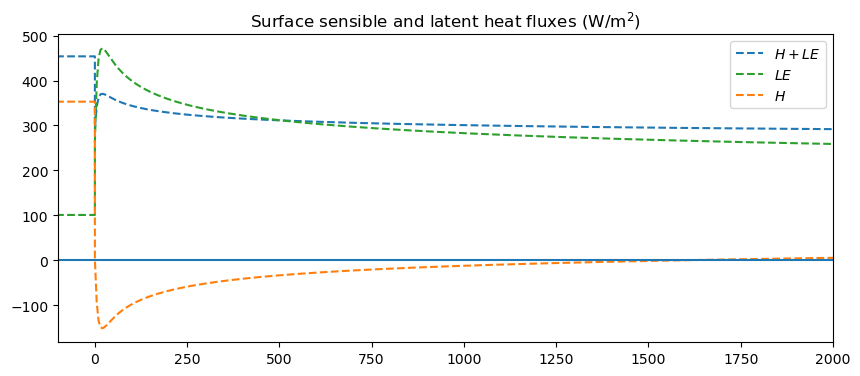

In [38]:
level = 5
plt.figure(figsize = (10, 4 ))
ax = plt.gca()

x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
xx = np.concatenate([-np.flip(x),x])

FluxTotal_upwind = FluxQ_upwind[level]*np.ones_like(x)*2.260*1e6/1000 + \
            FluxT_upwind[level]*np.ones_like(x)*1005*1.2

FluxTotal_ = np.concatenate([FluxTotal_upwind, FluxTotal[:, level]])



ax.plot(xx, FluxTotal_,  c =  'C0', ls = '--', label = '$H + LE$')


FluxQ = np.concatenate([ FluxQ_upwind[level]*np.ones_like(x), FluxQ_uniform[:, level]])
ax.plot(xx,FluxQ*2.260*1e6/1000,  ls = '--', c =  'C2',  label = "$LE$")

FluxT = np.concatenate([FluxT_upwind[level]*np.ones_like(x), FluxT_uniform[:,level]])
ax.plot(xx, FluxT*1005*1.2,  c =  'C1', ls = '--', label = "$H$")
ax.legend()
ax.set_title("Surface sensible and latent heat fluxes (W/m$^2$)")

level = 5
print (FluxQ_upwind[level]*2260,  FluxT_upwind[level]*1005*1.2)
print (FluxT_uniform[ -1, level]*1005*1.2, FluxQ_uniform[ -1, level]*2260)

ax.set_xlim(-100, 2000)
ax.axhline(0)

In [39]:
fig6data = pd.read_csv('baldocchi1995/baldocchi1995_fig6.csv')

In [54]:
ground = params['h']*2/3
params['h']

1

(4.316666666666667, 3.6500000000000004)

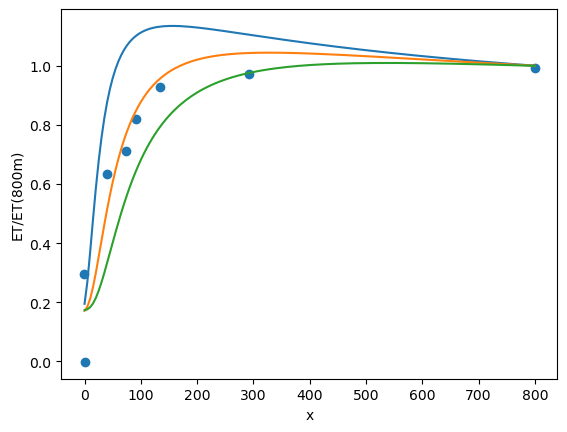

In [76]:
# z_measure - z_canopy = z_grid = z_ind*dz
level = int((4 - params['h']*2/3)/params['dz']) + 1

# level = int((4 - params['h'])/params['dz']) 
i800 = np.where(x > 800)[0][0]
plt.scatter(fig6data['x'], fig6data[' y'], label = "Baldocchi and Rao, 1995")
plt.plot(x[:i800], FluxQ_uniform[:i800, level]/FluxQ_uniform[i800, level])

level = int((6 - params['h']*2/3)/params['dz']) + 1
plt.plot(x[:i800], FluxQ_uniform[:i800, level]/FluxQ_uniform[i800, level])


level = int((8 - params['h']*2/3)/params['dz']) + 1
plt.plot(x[:i800], FluxQ_uniform[:i800, level]/FluxQ_uniform[i800, level])


plt.xlabel("x")
plt.ylabel("ET/ET(800m)")
# measurement heights above sublayer.
# not rigid canopy, potato canopy
level = int((4 - params['h']*2/3)/params['dz']) + 1
z[level] + params['h']*2/3, z[level] 

229.46934361720207

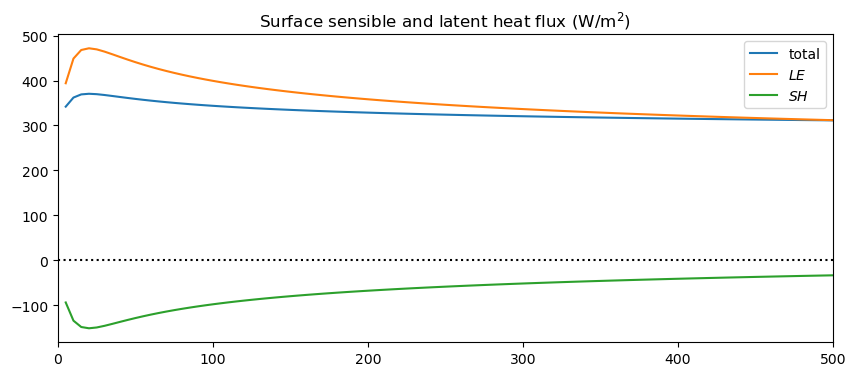

In [55]:
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

level = 5
plt.figure(figsize = (10,4))
ax = plt.gca()
ax.plot(x[1:], FluxTotal[1:, level], label = 'total')
ax.plot(x[1:], FluxQ_uniform[1:, level]*2.260*1e6/1000, label = "$LE$")
ax.plot(x[1:], FluxT_uniform[1:, level]*1005*1.2, label = "$SH$")
ax.axhline(FluxT_uniform[-1, level], ls = ':', c = 'k')
ax.legend()
ax.set_xlim(0, 500)
ax.set_title("Surface sensible and latent heat flux (W/m$^2$)")

FluxTotal[level, -1]

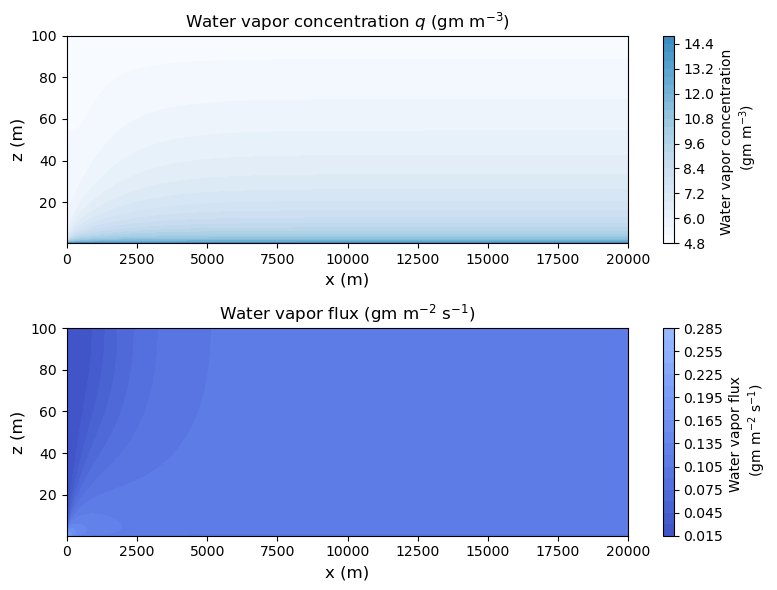

In [56]:
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_uniform.T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z, FluxQ_uniform.T.round(4),  20, cmap='coolwarm', vmin = 0, vmax = 1)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()



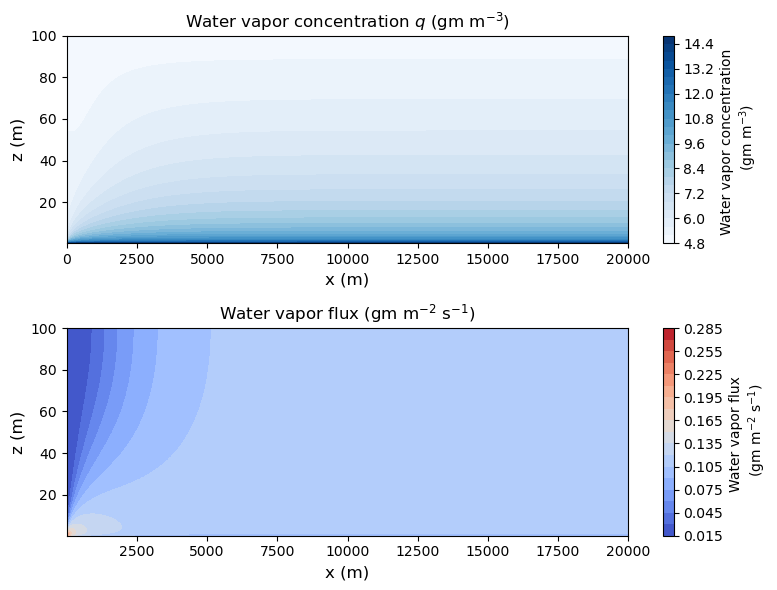

In [57]:


z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_uniform.T), 25, cmap='Blues',  )#vmax = Q_f, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x[1:], z, FluxQ_uniform[1:].T.round(4),  20, cmap='coolwarm')
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()


In [63]:
!open .

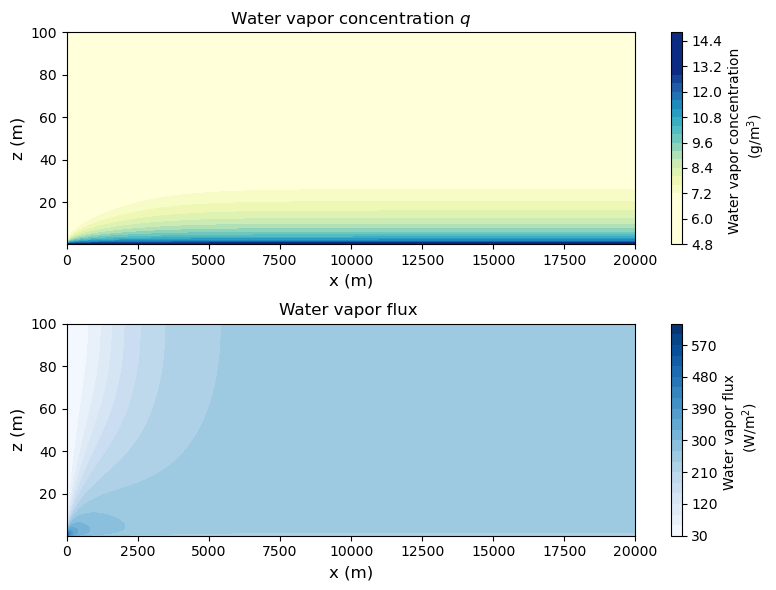

In [58]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

# Normalized concentration (if needed)
# Qd = (Q - Qa) / (Qs - Qa)
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_uniform.T), 25, cmap=custom_cmap,  vmax = 13, vmin = 7)
plt.colorbar(label='Water vapor concentration \n (g/m$^3$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ ', fontsize=12)

plt.subplot(2, 1, 2)

plt.contourf(x, z, FluxQ_uniform.T.round(4)*2260,  20, cmap='Blues') #vmin = -0.2, vmax = 0.5)
plt.colorbar(label='Water vapor flux \n (W/m$^2$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux ', fontsize=12)

plt.tight_layout()
plt.show()


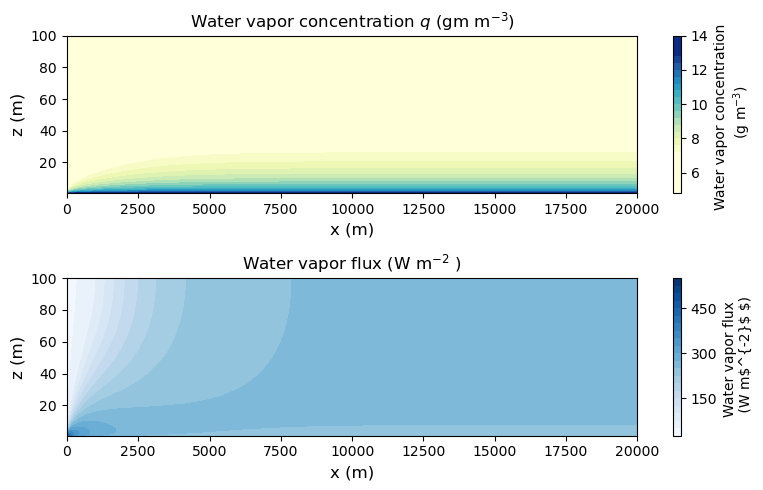

In [59]:
# Reduce the number of tick labels for colorbars
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.figure(figsize=(8,5))

# Subplot 1: Water vapor concentration
plt.subplot(2, 1, 1)
contour1 = plt.contourf(x, z[1:], Q_uniform[:, 1:].T, 25, cmap=custom_cmap, vmax=13, vmin=7)
cbar1 = plt.colorbar(contour1, label='Water vapor concentration \n (g m$^{-3}$)')
cbar1.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

# Subplot 2: Water vapor flux
plt.subplot(2, 1, 2)
contour2 = plt.contourf(x, z[3:], FluxQ_uniform[:, 3:].T.round(4)*2260, 20, cmap='Blues')
cbar2 = plt.colorbar(contour2, label='Water vapor flux \n (W m$^{-2}$ $)')
cbar2.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (W m$^{-2}$ )', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()
